In [2]:
import os

from PIL import Image
import matplotlib.pyplot as plt
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sshikamaru/car-object-detection")

import pandas as pd
df = pd.read_csv(path + "/data/train_solution_bounding_boxes (1).csv")
# image = name, xmin = bounding box xmin coord, ymin = bounding box ymin coord,
# xmax = bounding box xmax coord, ymax = bounding box ymax coord
df.head()




,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


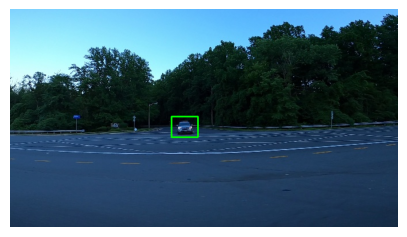

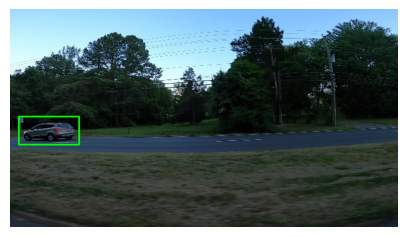

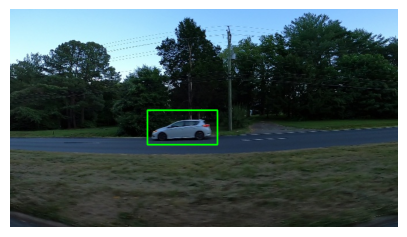

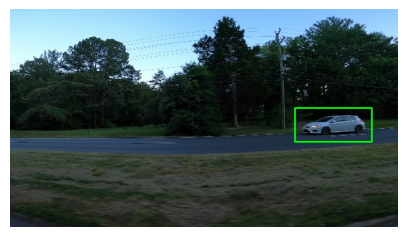

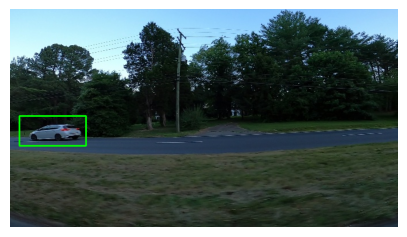

In [3]:
import cv2

# preview first 5 images in df with bounding boxes
for i in range(5):
    # get current row
    row = df.iloc[i]

    # obtain row values for image
    name = row["image"]

    # convert coordinates to ints to represent pixels
    xmin = int(row["xmin"])
    ymin = int(row["ymin"])
    xmax = int(row["xmax"])
    ymax = int(row["ymax"])

    # read image
    image = cv2.imread("/kaggle/input/car-object-detection/data/training_images/" + name)

    # draw rectangle to represent bounding box
    # (image, start point, end point, color, thickness)
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    # convert to rgb
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # display the image
    plt.figure(figsize=(5,5))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

In [4]:
# make directories for YOLO data structure

# make new directory to store data because kaggle dataset is read-only
os.makedirs("/kaggle/working/dataset", exist_ok=True)
for ext_dir in ["images", "labels"]:
  for int_dir in ["train", "val", "test"]:
    # os.path.join combines the file paths safely
    # exist_ok allows the path to be made even if it already exists
    os.makedirs(os.path.join("/kaggle/working/dataset", ext_dir, int_dir), exist_ok=True)


In [5]:
import shutil
# define function that takes each image in the training/validation set and
# 1. copies the image into its proper directory
# 2. calculates the center_x, center_y, width, and height of the bounding box
# 3. creates a text file containing these values and stores them in their proper directory
def get_annotation(df, folder):
  for idx, row in df.iterrows():
    # extract name, xmin, ymin, xmax, ymax from each image with a bounding box
    name = row["image"]
    xmin = row["xmin"]
    ymin = row["ymin"]
    xmax = row["xmax"]
    ymax = row["ymax"]

    # calculate center_x, center_y, width, and height
    width = xmax - xmin
    height = ymax - ymin
    center_x = (xmin + xmax) / 2
    center_y = (ymin + ymax) / 2

    # get image size
    with Image.open(os.path.join("/kaggle/input/car-object-detection/data/training_images", name)) as img:
      img_width, img_height = img.size

    # normalize data values
    width /= img_width
    height /= img_height
    center_x /= img_width
    center_y /= img_height

    # copy image to working dataset
    # shutil.copy copies a file from a source path to destination path
    shutil.copy(os.path.join("/kaggle/input/car-object-detection/data/training_images", name),
                os.path.join("/kaggle/working/dataset/images", folder, name))

    # create label .txt file for image
    # os.path.splittext splits a file with its root path and the extension
    # we use it to get the root name of the image (without its extension .jpg)
    # and add the .txt extension
    filepath = os.path.join("/kaggle/working/dataset/labels", folder, os.path.splitext(name)[0] + ".txt")

    # write to file
    with open(filepath, "w") as f:
      f.write(f"{0} {center_x} {center_y} {width} {height}")

In [6]:
from sklearn.model_selection import train_test_split
# split randomized dataset into training and validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# perform annotation on both datasets
get_annotation(train_df, "train")
get_annotation(val_df, "val")

In [7]:
# copy test images to working dataset to be evaluated by model
# after training
test_imgs = os.listdir("/kaggle/input/car-object-detection/data/testing_images")
for img in test_imgs:
  shutil.copy("/kaggle/input/car-object-detection/data/testing_images/" + img, "/kaggle/working/dataset/images/test/" + img)

In [8]:
# create yaml file to be passed to YOLO model
data = f"""
path: /kaggle/working/dataset

# training images
train: ../images/train

# validation images
val: ../images/val

# test images
test: ../images/test

# number of classes
nc: 1

# names of classes
names: ["car"]
"""

# create data.yaml file in working dataset and write to it
with open("data.yaml", "w") as f:
  f.write(data)

In [9]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
from ultralytics import YOLO


# Load a COCO-pretrained YOLO11n model
#model = YOLO("yolo11n.pt")

# Train the model on the COCO8 example dataset for 100 epochs
#results = model.train(data="coco8.yaml", epochs=100, imgsz=640)

#from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")

# Train the model
train_results = model.train(
    data="data.yaml",  # path to dataset YAML
    epochs=25,  # number of training epochs
    imgsz=640,
     batch=18,# training image size
    device="cpu",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
)

Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=data.yaml, epochs=25, time=None, patience=100, batch=18, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchsc

train: Scanning /kaggle/working/dataset/labels/train.cache... 307 images, 0 backgrounds, 0 corrupt: 100%|██████████| 307/307 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2019.6±794.1 MB/s, size: 86.1 KB)



val: Scanning /kaggle/working/dataset/labels/val.cache... 94 images, 0 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]

Plotting labels to runs/detect/train3/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005625000000000001), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
metrics = model.val()
metrics_dict = metrics.results_dict

mAP_50 = metrics_dict['metrics/mAP50(B)']  # mAP at IoU=0.5
mAP_50_95 = metrics_dict['metrics/mAP50-95(B)']

print(f"\nmAP@0.5: {mAP_50}")
print(f"\nmAP@0.5:0.95: {mAP_50_95}")

precision = metrics_dict['metrics/precision(B)']
recall = metrics_dict['metrics/recall(B)']
fitness = metrics_dict['fitness']

print(f"\nPrecision: {precision}")
print(f"\nRecall: {recall}")
print(f"\nFitness: {fitness}")

In [ ]:
images_path = '/kaggle/working/dataset/images/test/'

plt.figure(figsize=(10, 8))
imgs = random.sample(os.listdir(images_path), 5)

for img in imgs:
    results = model(images_path+img)
    results[0].show()